In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm  
import matplotlib.colors as mcolors
from matplotlib import rcParams
import scipy.constants as constants
from matplotlib.colors import LogNorm




nice_fonts = {
        # Use LaTeX to write all text
        #"text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 12,
        "font.size": 12,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
}

rcParams.update(nice_fonts)



figys = (6, 6*(.66))
rcParams['figure.figsize'] = figys
#rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = '--'
rcParams['xtick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['ytick.right'] = True

In [2]:


def TFN(tc, vol, ntes):
    n=5
    ep = 0.223e9
    g = ntes*n*vol*ep*tc**(n-1)
    f=0.5
    tfn = 4*constants.k*g*tc**2*f
    return tfn

def tau_sens(tc, vol, ntes):
    tb=10e-3
    n=5
    rp=2e-3
    rsh=5e-3
    r0=100e-3
    beta=2
    ep = 0.223e9
    g = ntes*n*vol*ep*tc**(n-1)
    alpha=1000
    gamma = 108
    fsc = 2.5
    c = fsc*gamma*ntes*vol*tc
    tau_m = c*np.sqrt(2*n)/(g*alpha)
    return tau_m
    
    #rl = rp+rsh
    #tau0=c/g
    #loop = alpha*(1-tb**n/tc**n)/n
    #return tau0*(1+beta+rl/r0)/(1+beta+rl/r0+(1-rl/r0)*loop)
    
    return tau_m

def tau_ph(det_vol, sens_a):
    f_trap = .2
    v = 2.5e4
    tau_ph = 4*det_vol/(v*sens_a)/f_trap
    return tau_ph

def get_al_area(ntes, qet_a, sa_face):
    active = ntes * qet_a
    cell = sa_face/ntes
    passive = 4e-6 * np.sqrt(cell) * ntes# + 150e-6*150e-6*2
    return active, passive


def collect_eff(active, passive):
    return active / (active + passive)
    
def noise(f, tc, vol, ntes):
    w = 2*np.pi*f
    
    return TFN(tc, vol, ntes)*(1+w**2*tau_sens(tc, vol, ntes)**2)

def res(tfn, tau_ph, tau_sens):
    return np.sqrt(tfn*(tau_ph + tau_sens))/constants.e

In [20]:
#det_surf_a = 45.6/(100**2)
det_thickness = 4e-3
width = 1e-2
surf_cov = 0.0025
vol_tes = 100e-6*2.5e-6*40e-9
qet_a = np.pi*100e-6*150e-6


surf_a = width*width*2 + width*det_thickness*4
det_vol = width*width*det_thickness

face_sa = width*width

ntes=100

active, passive = get_al_area(ntes,qet_a, face_sa)

## NEP vs Tc

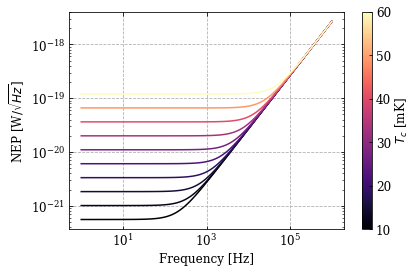

In [4]:
f = np.geomspace(1, 1e6, 100)


ntes = 1
tc = 40e-3

tcs = np.geomspace(10e-3, 60e-3, 10)

colormap = cm.get_cmap('magma')
normalize = mcolors.Normalize(vmin=min(tcs)*1e3, vmax=max(tcs)*1e3)





plt.figure(figsize=figys)
for ii, tc in enumerate(tcs):          
    plt.loglog(f, np.sqrt(noise(f, tc, vol_tes, ntes)), c=colormap(normalize(tc*1e3)))
plt.ylabel('NEP [W$/\sqrt{Hz}$]')
plt.xlabel('Frequency [Hz]')
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
#scalarmappaple.set_array(qets[:-1])
plt.grid()
cbar = plt.colorbar(scalarmappaple)
cbar.set_label('$T_c$ [mK]', labelpad = 3)
plt.tight_layout()
#plt.axvline(1/(2*np.pi*tau_ph(det_vol, sens_a)), linestyle='--')
#plt.savefig('noise.pdf', format='pdf', dpi=600)

## noise and Energy res vs Surface coverage and Tc

In [110]:
#pers = np.linspace(.0001, .15, 150)
ntes = np.linspace(1, 1000, 100)
tcs = np.linspace(10e-3, 60e-3, 100)
pers = np.ones(100)
active_arr = np.ones(100)
passive_arr = np.ones(100)
tau_sens_arr = np.ones(100)
tau_ph_arr = np.ones(100)
e_res = np.ones((100,100))
tfn_arr = np.ones((100,100))

pers_p = np.ones(100)
active_arr_p = np.ones(100)
passive_arr_p = np.ones(100)
tau_sens_arr_p = np.ones(100)
tau_ph_arr_p = np.ones(100)
e_res_p = np.ones((100,100))
tfn_arr_p = np.ones((100,100))


for ii, n in enumerate(ntes):
    active, passive = get_al_area(n, qet_a, face_sa)
    passive = 0
    active_arr[ii] = active
    passive_arr[ii] = passive
    pers[ii] = (active+passive)/surf_a
    tau_phonon = tau_ph(det_vol, active+passive)
    tau_ph_arr[ii] = tau_phonon
    #print(collect_eff(active, passive))
    for jj, tc in enumerate(tcs):
        tfn = TFN(tc, vol_tes, n)
        tfn_arr[jj,ii] = tfn
        tau_m = tau_sens(tc, vol_tes, n)
        
        tau_sens_arr[jj] = tau_m
        e_res[jj,ii] = res(tfn, tau_phonon, tau_m)/(collect_eff(active, passive))
        
for ii, n in enumerate(ntes):
    active, passive = get_al_area(n, qet_a, face_sa)
    active_arr_p[ii] = active
    passive_arr_p[ii] = passive
    pers_p[ii] = (active+passive)/surf_a
    tau_phonon = tau_ph(det_vol, active+passive)
    tau_ph_arr_p[ii] = tau_phonon
    #print(collect_eff(active, passive))
    for jj, tc in enumerate(tcs):
        tfn = TFN(tc, vol_tes, n)
        tfn_arr_p[jj,ii] = tfn
        tau_m = tau_sens(tc, vol_tes, n)
        
        tau_sens_arr_p[jj] = tau_m
        e_res_p[jj,ii] = res(tfn, tau_phonon, tau_m)/(collect_eff(active, passive))
        


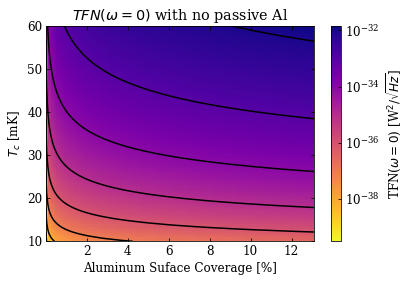

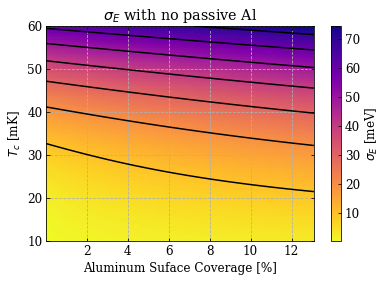

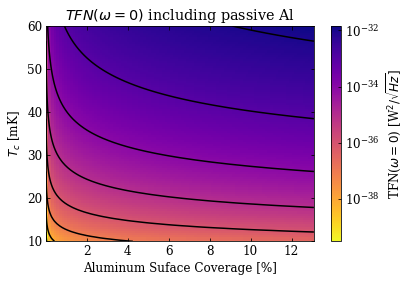

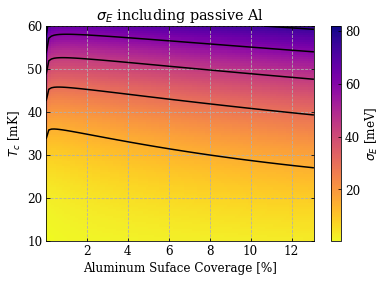

In [111]:
Y = tcs*1e3
X = pers*100

plt.figure()
Z = tfn_arr*1e3
plt.title("$TFN(\omega=0)$ with no passive Al")
plt.pcolor(X, Y, Z, norm=LogNorm(np.min(Z[np.nonzero(Z)]), Z.max()), cmap='plasma_r')
plt.colorbar(label='TFN($ω=0$) [W$^2/\sqrt{Hz}$]')
plt.contour(X,Y, Z, levels=10, norm=LogNorm(np.min(tfn_arr[np.nonzero(tfn_arr)]), tfn_arr.max()),
                                           colors='black')
plt.ylabel('$T_c$ [mK]')
plt.xlabel('Aluminum Suface Coverage [%]')


plt.figure()
Z = e_res*1e3
plt.title("$\sigma_E$ with no passive Al")
plt.pcolor(X, Y, Z, cmap='plasma_r')
plt.colorbar(label='$\sigma_E$ [meV]')
plt.contour(X,Y, Z, colors='black')
plt.ylabel('$T_c$ [mK]')
plt.xlabel('Aluminum Suface Coverage [%]')
plt.grid()

###

plt.figure()
Z = tfn_arr_p*1e3
plt.title("$TFN(\omega=0)$ including passive Al")
plt.pcolor(X, Y, Z, norm=LogNorm(np.min(Z[np.nonzero(Z)]), Z.max()), cmap='plasma_r')
plt.colorbar(label='TFN($ω=0$) [W$^2/\sqrt{Hz}$]')
plt.contour(X,Y, Z, levels=10, norm=LogNorm(np.min(tfn_arr[np.nonzero(tfn_arr)]), tfn_arr.max()),
                                           colors='black')
plt.ylabel('$T_c$ [mK]')
plt.xlabel('Aluminum Suface Coverage [%]')


plt.figure()
Z = e_res_p*1e3
plt.title("$\sigma_E$ including passive Al")
plt.pcolor(X, Y, Z, cmap='plasma_r')
plt.colorbar(label='$\sigma_E$ [meV]')
plt.contour(X,Y, Z, colors='black')
plt.ylabel('$T_c$ [mK]')
plt.xlabel('Aluminum Suface Coverage [%]')
plt.grid()




Text(0.5, 0, '$T_c$ [mK]')

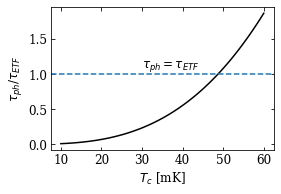

In [8]:
plt.figure(figsize=(4,4*.66))
plt.plot(tcs*1e3, tau_ph_arr_p[-1]/tau_sens_arr_p, color='k')
plt.axhline(1, linestyle='--')
plt.annotate(r'$\tau_{ph} = \tau_{ETF}$', (30,1.1))
plt.ylabel(r'$\tau_{ph}/\tau_{ETF}$')
plt.xlabel('$T_c$ [mK]')

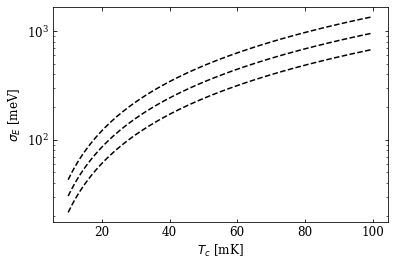

In [60]:

active, passive = get_al_area(ntes, qet_a, face_sa)
passive = 0

ntes=100000

    
tau_phonon = tau_ph(det_vol, active+passive)
vol_tes = 100e-6*2.5e-6*40e-9
vol = [vol_tes*2, vol_tes, vol_tes/2]
tcs = np.linspace(10e-3, 100e-3, 100)
e_res = np.ones(100)
for v in vol:
    for ii, tc in enumerate(tcs):

        tfn = TFN(tc, v, ntes)
        tau_m = tau_sens(tc, v, ntes)
        e_res[ii] = res(tfn, 0, tau_m)
    plt.plot(tcs*1e3, e_res*1e3, linestyle='--', color='k')
    #plt.plot(tcs*1e3, 3e4*np.sqrt(tcs**3))
    plt.yscale('log')
    plt.xlabel('$T_c$ [mK]')
    plt.ylabel('$\sigma_E$ [meV]')

## Study active and passive area effect on resolution 

In [119]:
#pers = np.linspace(.0001, .15, 150)

tc =60e-3
n = 1000
ntes = np.linspace(10, 1000, n)

pers = np.ones(n)
active_arr = np.ones(n)
passive_arr = np.ones(n)
tau_sens_arr = np.ones(n)
tau_ph_arr = np.ones(n)
e_res = np.ones(n)
tfn_arr = np.ones(n)
c_eff = np.ones(n)

pers_p = np.ones(n)
active_arr_p = np.ones(n)
passive_arr_p = np.ones(n)
tau_sens_arr_p = np.ones(n)
tau_ph_arr_p = np.ones(n)
e_res_p = np.ones(n)
tfn_arr_p = np.ones(n)
c_eff_p = np.ones(n)


for ii, n in enumerate(ntes):
    active, passive = get_al_area(n, qet_a, face_sa)
    passive = 0
    active_arr[ii] = active
    passive_arr[ii] = passive
    pers[ii] = (active+passive)/surf_a
    tau_phonon = tau_ph(det_vol, active+passive)
    tau_ph_arr[ii] = tau_phonon
    #print(collect_eff(active, passive))
    #for jj, tc in enumerate(tcs):
    tfn = TFN(tc, vol_tes, n)
    tfn_arr[ii] = tfn
    tau_m = tau_sens(tc, vol_tes, n)
    c_eff[ii] = collect_eff(active, passive)
    tau_sens_arr[ii] = tau_m
    e_res[ii] = res(tfn, tau_phonon, tau_m)/(collect_eff(active, passive))
        
for ii, n in enumerate(ntes):
    active, passive = get_al_area(n, qet_a, face_sa)
    active_arr_p[ii] = active
    passive_arr_p[ii] = passive
    pers_p[ii] = (active+passive)/surf_a
    tau_phonon = tau_ph(det_vol, active+passive)
    tau_ph_arr_p[ii] = tau_phonon
    #print(collect_eff(active, passive))
    tfn = TFN(tc, vol_tes, n)
    tfn_arr_p[ii] = tfn
    tau_m = tau_sens(tc, vol_tes, n)
    tau_sens_arr_p[ii] = tau_m
    c_eff_p[ii] = collect_eff(active, passive)
    e_res_p[ii] = res(tfn, tau_phonon, tau_m)/(collect_eff(active, passive))
        


(0.0, 6.0)

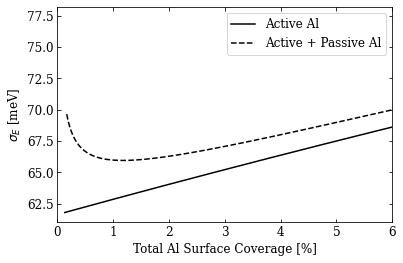

In [120]:
x_p = (active_arr_p + passive_arr_p)/surf_a * 100
x = active_arr/surf_a * 100
plt.plot(x, e_res*1000, label='Active Al', color='k')
plt.plot(x_p, e_res_p*1000, label='Active + Passive Al', color='k', linestyle='--')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.xlabel('Total Al Surface Coverage [%]')
plt.ylabel('$\sigma_E$ [meV]')
plt.xlim(0, 6)

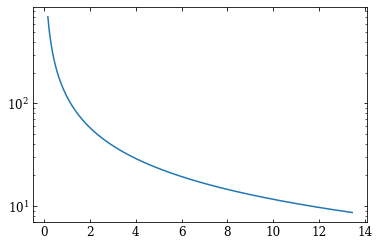

In [109]:

plt.plot(x_p, tau_ph_arr_p/tau_sens_arr_p)
plt.yscale('log')

In [ ]:
tau_

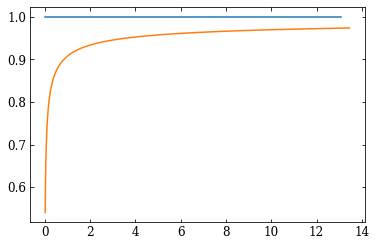

In [81]:
x_p = (active_arr_p + passive_arr_p)/surf_a * 100
x = active_arr/surf_a * 100
plt.plot(x, c_eff)
plt.plot(x_p, c_eff_p)
#plt.yscale('log')
#plt.xscale('log')

ValueError: x and y must have same first dimension, but have shapes (100,) and (1000,)

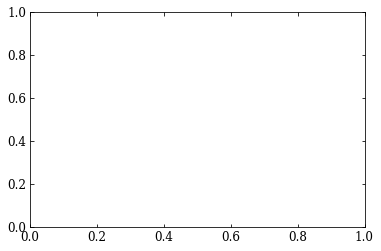

In [82]:
plt.plot(tcs*1e3, e_res*1e3, linestyle='--', color='k')
#plt.plot(tcs*1e3, 3e4*np.sqrt(tcs**3))
plt.yscale('log')
plt.xlabel('$T_c$ [mK]')
plt.ylabel('$\sigma_E$ [meV]')

In [55]:
ntes = #, .00000000000001]
vol = 100e-6*2.5e-6*40e-9
qet_a = np.pi*100e-6*150e-6
#pers=[.0025]
cmap = cm.get_cmap('viridis_r')
c = cmap(np.linspace(0, 1, len(pers)+1))
marker = ['x', '.','o','+']
#tau_senss = []
#tau_phonons = []
plt.figure(figsize=figys)
for jj, p in enumerate(pers):
    sens_a = det_surf_a*p*2
    ntes = int(sens_a/(qet_a))
    resis = np.ones_like(tcs)
    for ii, tc in enumerate(tcs):
        tfn = TFN(tc, vol, ntes)
        tau_m = tau_sens(tc, vol, ntes)
        #tau_senss.append(tau_m)
        #tau_phonons.append(tau_ph(det_vol, sens_a))
        reso = res(tfn, tau_ph(det_vol, sens_a), tau_m)#/(collect_eff(1, det_vol, sens_a)**2)
        resis[ii] = reso
        #print(f'tc = {tc*1e3:.1f} [mK], σ = {reso*1e3:.1f} [meV]')
    plt.plot(tcs*1e3, resis, linestyle='none', marker=marker[jj], color=c[jj+1],  markersize=5, label=f'{p*100:.2f}\%')
    #plt.plot(tcs*1e3, 6e10*np.sqrt(vol*tcs**6))
    plt.yscale('log')
    #plt.xscale('log')
plt.legend()
plt.ylabel(r'Estimated Resolution [eV]')
plt.xlabel('$T_c$ [mK]')
plt.tight_layout()
#plt.savefig('resolution.pdf', format='pdf', dpi=600)

NameError: name 'det_surf_a' is not defined

<Figure size 432x285.12 with 0 Axes>

In [ ]:
pers = np.linspace(.002,.08, 100)#, .00000000000001]
vol = 100e-6*2.5e-6*40e-9
qet_a = np.pi*100e-6*150e-6
#pers=[.0025]
cmap = cm.get_cmap('viridis_r')
det_thickness = 4e-3
det_surf_a = width*width*2 + width*det_thickness*4
det_vol = width*width*det_thickness
tcs = [15e-3, 20e-3, 30e-3,40e-3,70e-3]
c = cmap(np.linspace(0, 1, len(tcs)+1))
marker = ['x', '.','o','+', '.']
#tau_senss = []
#tau_phonons = []
plt.figure(figsize=figys)
for jj, tc in enumerate(tcs):
    resis = np.ones_like(pers)
    for ii, p in enumerate(pers):
        sens_a = det_surf_a*p
        ntes = int(sens_a/(qet_a/4))
        #print(ntes)
        tfn = TFN(tc, vol, ntes)
        tau_m = tau_sens(tc, vol, ntes)
        #tau_senss.append(tau_m)
        #tau_phonons.append(tau_ph(det_vol, sens_a))
        reso = res(tfn, tau_ph(det_vol, sens_a), tau_m)#/(collect_eff(1, det_vol, sens_a)**2)
        resis[ii] = reso
        #print(f'tc = {tc*1e3:.1f} [mK], σ = {reso*1e3:.1f} [meV]')
    plt.plot(pers*1e2, resis*1e3, linestyle='-', marker=None, color=c[jj+1],  markersize=5, label=f'{tc*1e3:.2f} [mK]')
    #plt.plot(tcs*1e3, 6e10*np.sqrt(vol*tcs**6))
    plt.yscale('log')
    #plt.xscale('log')
plt.legend(loc=1)
plt.ylabel(r'Estimated Resolution [meV]')
plt.xlabel('Surface Coverage [\%]')
plt.tight_layout()
plt.savefig('sa.pdf')